In [1]:
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from collections import defaultdict

from transformers import AutoTokenizer, AutoModelWithLMHead
from transformers import *

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import tools.models as models
import tools.dataloaders as dataloaders
import tools.all_test_forBERT as all_test_forBERT
import tools.loaddatasets as loaddatasets
import tools.testForTask as testForTask
import tools.draw as draw

In [3]:
model_name = 'bert-base-uncased'
if model_name == 'bert-base-uncased':
    emb_type = 'base'
if model_name == 'bert-large-uncased':
    emb_type = 'large'
    
# list ds for testing
D = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30,35,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

In [4]:
word_simi_train_file = 'datasets//word_simi_train.csv'
word_simi_test_file = 'datasets//word_simi_test.csv'
analogy_test_file = 'datasets//word_analogy.csv'
text_simi_test_file = 'datasets//text_simi.csv'

In [5]:
bert_model = BertModel.from_pretrained(model_name)
bert_model.eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
embedding = bert_model.get_input_embeddings()

ids = torch.tensor(range(30522))
E = embedding(ids).detach().numpy()
print('BERT Embedding shape check:', E.shape)

emb_dimension = E.shape[1]
vocab_len = E.shape[0]

BERT Embedding shape check: (30522, 768)


In [6]:
#load U
U = np.load('trained-embedding//U_%s.npy' % emb_type )
E = torch.tensor(E)
print(E.shape)
print(U.shape)

torch.Size([30522, 768])
(768, 768)


In [7]:

word_simi_train, word_simi_test,analogy_test, text_simi_test = \
loaddatasets.load_datasets(bert_tokenizer, embedding, word_simi_train_file, word_simi_test_file, analogy_test_file, text_simi_test_file)

word similarity training dataset shape: (7703, 7)
   index   word1     word2  simi dataset_name  \
0    611   misty   weather  0.48      men3000   
1    530  parrot      wing  0.52      men3000   
2   2787     bay  chipmunk -0.72      men3000   

                                                  e1  \
0  [tensor(-0.0009), tensor(0.0425), tensor(0.018...   
1  [tensor(-0.0032), tensor(0.0592), tensor(0.026...   
2  [tensor(-0.0462), tensor(-0.0383), tensor(0.00...   

                                                  e2  
0  [tensor(-0.0026), tensor(-0.0180), tensor(-0.0...  
1  [tensor(0.0337), tensor(-0.0694), tensor(-0.01...  
2  [tensor(-0.0786), tensor(-0.2977), tensor(0.01...  
(2447, 10)
   index     word1     word2  simi dataset_name      id1      id2  id_num  \
0   1801      jean   washing -0.16      men3000   [3744]  [12699]       2   
1   1190   blurred      lens  0.20      men3000  [18449]  [10014]       2   
2   1817     lunch   morning -0.16      men3000   [6265]   [2851] 

# Oringinal embedding results 

In [8]:
# add results of original embedding to dataframe
word_simi_result = testForTask.word_similarity(word_simi_test,E.numpy(),bert_tokenizer,0,'original')
text_simi_result = testForTask.text_similarity(text_simi_test, E.numpy(), bert_tokenizer,0,'original')
analogy_result = testForTask.word_analogy(analogy_test,E.numpy(), bert_tokenizer,0,'original')
print(analogy_result.head())

   index   word1   word2    word3        word4              dataset_name  \
0      0  Athens  Greece  Baghdad         Iraq  capital-common-countries   
1      1  Athens  Greece  Bangkok     Thailand  capital-common-countries   
2      2  Athens  Greece  Beijing        China  capital-common-countries   
3      3  Athens  Greece   Berlin      Germany  capital-common-countries   
4      4  Athens  Greece     Bern  Switzerland  capital-common-countries   

       part   id1   id2    id3   id4  id_num  original_0  
0  semantic  7571  5483  13952  5712       4           1  
1  semantic  7571  5483  12627  6504       4           1  
2  semantic  7571  5483   7211  2859       4           0  
3  semantic  7571  5483   4068  2762       4           1  
4  semantic  7571  5483  16595  5288       4           0  


# CN(Conceptor Negation) results 

In [9]:
#get embedding processed by CN

x_collector = E.numpy().T
#x_collector.shape = (emb_dim, V)
nrWords = x_collector.shape[1] # number of total words
R = x_collector.dot(x_collector.T) / nrWords # calculate the un-centered correlation matrix
#R.shape = (emb_dim, emb_dim)
C = R @ np.linalg.inv(R + 2 ** (-2) * np.eye(emb_dimension))# calculate the conceptor matrix
#C.shape = (emb_dim, emb_dim)
vecMatrix = ((np.eye(emb_dimension) - C) @ x_collector).T 
#vecMatrix.shape = (V, emb_dim) -> NEW EMB

CN_emb = vecMatrix
print("CN_emb.shape:", CN_emb.shape)

CN_emb.shape: (30522, 768)


In [10]:
# add results of CN embedding to dataframe
word_simi_result = testForTask.word_similarity(word_simi_test,CN_emb,bert_tokenizer,0,'cn')
text_simi_result = testForTask.text_similarity(text_simi_test, CN_emb, bert_tokenizer,0,'cn')
analogy_result = testForTask.word_analogy(analogy_test,CN_emb, bert_tokenizer,0,'cn')
print(analogy_result.head())

   index   word1   word2    word3        word4              dataset_name  \
0      0  Athens  Greece  Baghdad         Iraq  capital-common-countries   
1      1  Athens  Greece  Bangkok     Thailand  capital-common-countries   
2      2  Athens  Greece  Beijing        China  capital-common-countries   
3      3  Athens  Greece   Berlin      Germany  capital-common-countries   
4      4  Athens  Greece     Bern  Switzerland  capital-common-countries   

       part   id1   id2    id3   id4  id_num  original_0  cn_0  
0  semantic  7571  5483  13952  5712       4           1     1  
1  semantic  7571  5483  12627  6504       4           1     1  
2  semantic  7571  5483   7211  2859       4           0     1  
3  semantic  7571  5483   4068  2762       4           1     1  
4  semantic  7571  5483  16595  5288       4           0     1  


# ABTT(all-but-the-top) results

In [11]:
#calculate results for each abtt-d embedding and add to dataframe

for d in D:
    print("d = ", d)
    
    #get abtt-d embedding
    coe = torch.matmul(E,torch.tensor(U[:d]).T)
    U_coe = torch.matmul(coe, torch.tensor(U[:d]))
    ABTT_Emb = E - U_coe
    
    #calculate results
    word_simi_result = testForTask.word_similarity(word_simi_test,ABTT_Emb.numpy(),bert_tokenizer,d,'abtt')
    text_simi_result = testForTask.text_similarity(text_simi_test, ABTT_Emb.numpy(), bert_tokenizer,d,'abtt')
    analogy_result = testForTask.word_analogy(analogy_test,ABTT_Emb.numpy(), bert_tokenizer,d,'abtt')
    
print(word_simi_result.head())
print(text_simi_result.head())
print(analogy_result.head())

d =  1
d =  2
d =  3
   index     word1     word2  simi dataset_name      id1      id2  id_num  \
0   1801      jean   washing -0.16      men3000   [3744]  [12699]       2   
1   1190   blurred      lens  0.20      men3000  [18449]  [10014]       2   
2   1817     lunch   morning -0.16      men3000   [6265]   [2851]       2   
3   2505   animals  sandwich -0.56      men3000   [4176]  [11642]       2   
4   1117  bathroom     floor  0.24      men3000   [5723]   [2723]       2   

                                                  e1  \
0  [tensor(-0.0434), tensor(-0.0364), tensor(-0.0...   
1  [tensor(0.0293), tensor(-0.0504), tensor(-0.05...   
2  [tensor(-0.0198), tensor(0.0124), tensor(0.002...   
3  [tensor(-0.0320), tensor(0.0323), tensor(-0.04...   
4  [tensor(0.0495), tensor(-0.0157), tensor(-0.04...   

                                                  e2  original_0      cn_0  \
0  [tensor(-0.0351), tensor(-0.0446), tensor(-0.0...    0.401823  0.080372   
1  [tensor(-0.0126), te

# WR(weighted removal) results

In [12]:
#计算每个d对应的WR结果
for d in D:
    print("d = ", d)
    
    WR_Emb = np.load('trained-embedding/%sEmb_%s.npy' % (emb_type, d))
    
    word_simi_result = testForTask.word_similarity(word_simi_test,WR_Emb,bert_tokenizer,d,'wr')
    text_simi_result = testForTask.text_similarity(text_simi_test, WR_Emb, bert_tokenizer,d,'wr')
    analogy_result = testForTask.word_analogy(analogy_test,WR_Emb, bert_tokenizer,d,'wr')
    
print(word_simi_result.head())
print(text_simi_result.head())
print(analogy_result.head())

d =  1
d =  2
d =  3
   index     word1     word2  simi dataset_name      id1      id2  id_num  \
0   1801      jean   washing -0.16      men3000   [3744]  [12699]       2   
1   1190   blurred      lens  0.20      men3000  [18449]  [10014]       2   
2   1817     lunch   morning -0.16      men3000   [6265]   [2851]       2   
3   2505   animals  sandwich -0.56      men3000   [4176]  [11642]       2   
4   1117  bathroom     floor  0.24      men3000   [5723]   [2723]       2   

                                                  e1  \
0  [tensor(-0.0434), tensor(-0.0364), tensor(-0.0...   
1  [tensor(0.0293), tensor(-0.0504), tensor(-0.05...   
2  [tensor(-0.0198), tensor(0.0124), tensor(0.002...   
3  [tensor(-0.0320), tensor(0.0323), tensor(-0.04...   
4  [tensor(0.0495), tensor(-0.0157), tensor(-0.04...   

                                                  e2  original_0      cn_0  \
0  [tensor(-0.0351), tensor(-0.0446), tensor(-0.0...    0.401823  0.080372   
1  [tensor(-0.0126), te

In [13]:
word_simi_result = word_simi_result.drop(columns = ['index','id1','id2','id_num','e1','e2'])
text_simi_result = text_simi_result.drop(columns = ['genre','filename','index'])
analogy_result = analogy_result.drop(columns = ['index','id1','id2','id3','id4','id_num'])
    
print(word_simi_result.head())
print(text_simi_result.head())
print(analogy_result.head())

      word1     word2  simi dataset_name  original_0      cn_0    abtt_1  \
0      jean   washing -0.16      men3000    0.401823  0.080372  0.346343   
1   blurred      lens  0.20      men3000    0.483433  0.156959  0.393124   
2     lunch   morning -0.16      men3000    0.353680  0.167502  0.320340   
3   animals  sandwich -0.56      men3000    0.307417 -0.044695  0.241552   
4  bathroom     floor  0.24      men3000    0.314693  0.101426  0.283092   

     abtt_2    abtt_3      wr_1      wr_2      wr_3  
0  0.125579  0.103804  0.346343  0.125579  0.103804  
1  0.232899  0.163852  0.393124  0.232899  0.163852  
2  0.203650  0.187971  0.320340  0.203650  0.187971  
3  0.016998 -0.022946  0.241552  0.016998 -0.022946  
4  0.168738  0.142220  0.283092  0.168738  0.142220  
   year  score                                          sent1  \
0  2012   5.00                         A plane is taking off.   
1  2012   3.80                A man is playing a large flute.   
2  2012   3.80  A man is

In [14]:
word_simi_result.to_csv('results/word_simi_result_%s.csv' % emb_type,index = False)
text_simi_result.to_csv('results/text_simi_result_%s.csv' % emb_type,index = False)
analogy_result.to_csv('results/analogy_result_%s.csv' % emb_type,index = False)

# calculate the overall results of each method

In [15]:
# load dataset
word_simi_result = pd.read_csv('results/word_simi_result_%s.csv' % emb_type)
text_simi_result = pd.read_csv('results/text_simi_result_%s.csv' % emb_type)
analogy_result = pd.read_csv('results/analogy_result_%s.csv' % emb_type)

method_list = list(word_simi_result.columns[4:])
overall = pd.DataFrame()
overall['method'] = method_list
corr_ws = []
ana_acc = []
corr_ts = []

for method in method_list:
    column_name = '%s' % method
 
    corr_ws.append(word_simi_result[['simi',column_name]].corr('pearson')['simi'][column_name])
    corr_ts.append(text_simi_result[['score',column_name]].corr('pearson')['score'][column_name])
    ana_acc.append(analogy_result[column_name].sum()/analogy_result.shape[0])

overall['word_simi'] = corr_ws
overall['analogy'] = ana_acc
overall['text_simi'] = corr_ts

overall

,method,word_simi,analogy,text_simi
0,original_0,0.404752,0.724371,0.613912
1,cn_0,0.537707,0.790439,0.507233
2,abtt_1,0.518719,0.757940,0.612735
3,abtt_2,0.545617,0.792332,0.611373
4,abtt_3,0.548792,0.796692,0.612954
5,wr_1,0.518719,0.757940,0.612735
6,wr_2,0.545617,0.792332,0.611373
7,wr_3,0.548792,0.796692,0.612954


D:\jupyterFile\code for Learn-to-remove\tools\draw.py:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize = 12


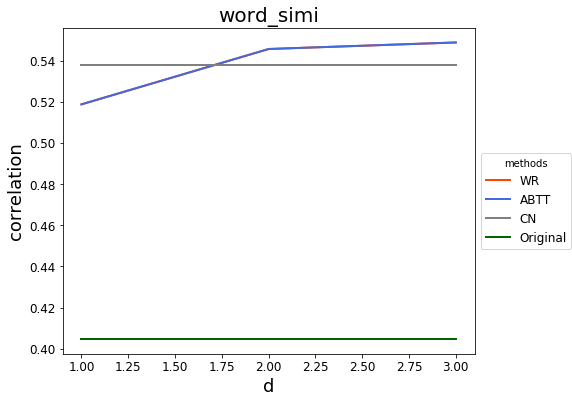

D:\jupyterFile\code for Learn-to-remove\tools\draw.py:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize = 12


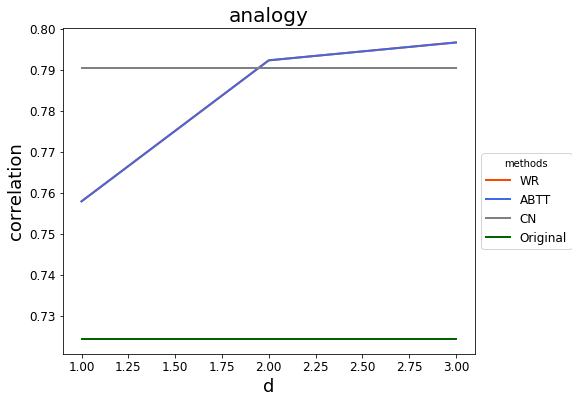

D:\jupyterFile\code for Learn-to-remove\tools\draw.py:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fontsize = 12


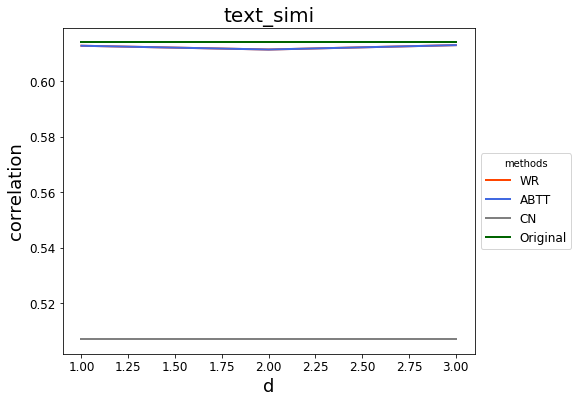

In [16]:
# visualize overall results
# word similarity
task_name = 'word_simi'
original_result = overall[task_name][0]
cn_result = overall[task_name][1]
abtt_result_ds = overall[task_name][2:2+len(D)]
wr_result_ds = overall[task_name][2+len(D):]

draw.draw_overall(original_result, cn_result, abtt_result_ds, wr_result_ds,D,task_name,emb_type)

# word analogy
task_name = 'analogy'
original_result = overall[task_name][0]
cn_result = overall[task_name][1]
abtt_result_ds = overall[task_name][2:2+len(D)]
wr_result_ds = overall[task_name][2+len(D):]

draw.draw_overall(original_result, cn_result, abtt_result_ds, wr_result_ds,D,task_name,emb_type)

# textual similarity
task_name = 'text_simi'
original_result = overall[task_name][0]
cn_result = overall[task_name][1]
abtt_result_ds = overall[task_name][2:2+len(D)]
wr_result_ds = overall[task_name][2+len(D):]

draw.draw_overall(original_result, cn_result, abtt_result_ds, wr_result_ds,D,task_name,emb_type)


# dataset wise

In [17]:
word_simi_datasets = pd.DataFrame()
word_simi_datasets['method'] = method_list

for name, group in word_simi_result.groupby('dataset_name'):
    print(name)
    print(group.shape)
    corr_d = []
    for method in method_list:
        column_name = '%s' % method
        corr_pearson = group[['simi',column_name]].corr('pearson')['simi'][column_name]
        corr_d.append(corr_pearson)
    word_simi_datasets[name] = corr_d

RG65
(19, 12)
SimVerb3500
(814, 12)
men3000
(804, 12)
mturk287
(82, 12)
mturk771
(223, 12)
rw2034
(121, 12)
simlex999
(289, 12)
wordsim353
(95, 12)


In [18]:
word_simi_datasets.to_csv('results/word_simi_ofdatasets_%s.csv' %(emb_type))
word_simi_datasets

,method,RG65,SimVerb3500,men3000,mturk287,mturk771,rw2034,simlex999,wordsim353
0,original_0,0.769605,0.299866,0.517756,0.370755,0.529512,0.493076,0.492522,0.569628
1,cn_0,0.855125,0.412289,0.673437,0.716855,0.652382,0.665845,0.549190,0.637373
2,abtt_1,0.834851,0.421033,0.643330,0.625898,0.600442,0.626323,0.551557,0.601853
3,abtt_2,0.838947,0.418469,0.692943,0.710402,0.659822,0.666294,0.565211,0.661412
4,abtt_3,0.835485,0.417565,0.699468,0.728491,0.664793,0.668062,0.566215,0.661808
5,wr_1,0.834851,0.421033,0.643330,0.625898,0.600442,0.626323,0.551557,0.601853
6,wr_2,0.838947,0.418469,0.692943,0.710402,0.659822,0.666294,0.565211,0.661412
7,wr_3,0.835485,0.417565,0.699468,0.728491,0.664793,0.668062,0.566215,0.661808


In [19]:
text_simi_datasets = pd.DataFrame()
text_simi_datasets['method'] = method_list

for name, group in text_simi_result.groupby('year'):
    print(name)
    print(group.shape)
    corr_d = []
    for method in method_list:
        column_name = '%s' % method
        corr_pearson = group[['score',column_name]].corr('pearson')['score'][column_name]
        corr_d.append(corr_pearson)
    text_simi_datasets[name] = corr_d

2012
(3000, 12)
2013
(750, 12)
2014
(2250, 12)
2015
(1875, 12)
2016
(503, 12)
2017
(250, 12)


In [20]:
text_simi_datasets.to_csv('results/text_simi_result_datasets_%s.csv' %(emb_type))
text_simi_datasets

,method,2012,2013,2014,2015,2016,2017
0,original_0,0.645909,0.660138,0.562252,0.639118,0.519960,0.616728
1,cn_0,0.596568,0.662557,0.477109,0.516015,0.436892,0.577096
2,abtt_1,0.657354,0.674574,0.571489,0.631458,0.514225,0.624735
3,abtt_2,0.651182,0.703136,0.576570,0.647835,0.495927,0.674836
4,abtt_3,0.645365,0.708122,0.578679,0.657331,0.495537,0.682573
5,wr_1,0.657354,0.674574,0.571489,0.631458,0.514225,0.624735
6,wr_2,0.651182,0.703136,0.576570,0.647835,0.495927,0.674836
7,wr_3,0.645365,0.708122,0.578679,0.657331,0.495537,0.682573


In [21]:
analogy_parts = pd.DataFrame()
analogy_parts['method'] = method_list

for name, group in analogy_result.groupby('part'):
    print(name)
    print(group.shape)
    acc = []
    for method in method_list:
        column_name = '%s' % method
        sum_d = group[column_name].sum()
        acc.append(sum_d/group.shape[0])
    analogy_parts[name] = acc

semantic
(4263, 14)
syntactic
(7891, 14)


In [22]:
analogy_parts.to_csv('results/analogy_part_%s.csv' %(emb_type))
analogy_parts

,method,semantic,syntactic
0,original_0,0.655172,0.761754
1,cn_0,0.768473,0.802306
2,abtt_1,0.698804,0.789887
3,abtt_2,0.779967,0.799012
4,abtt_3,0.785362,0.802813
5,wr_1,0.698804,0.789887
6,wr_2,0.779967,0.799012
7,wr_3,0.785362,0.802813


In [23]:
analogy_datasets = pd.DataFrame()
analogy_datasets['method'] = method_list

for name, group in analogy_result.groupby('dataset_name'):
    print(name)
    print(group.shape)
    acc = []
    for method in method_list:
        column_name = '%s' % method
        sum_d = group[column_name].sum()
        acc.append(sum_d/group.shape[0])
    analogy_datasets[name] = acc

capital-common-countries
(506, 14)
capital-world
(1500, 14)
city-in-state
(1823, 14)
currency
(54, 14)
family
(380, 14)
gram1-adjective-to-adverb
(930, 14)
gram2-opposite
(182, 14)
gram3-comparative
(1190, 14)
gram4-superlative
(380, 14)
gram5-present-participle
(930, 14)
gram6-nationality-adjective
(1299, 14)
gram7-past-tense
(1482, 14)
gram8-plural
(992, 14)
gram9-plural-verbs
(506, 14)


In [24]:
analogy_datasets.to_csv('results/analogy_datasets_%s.csv' %(emb_type))
analogy_datasets

,method,capital-common-countries,capital-world,city-in-state,currency,family,gram1-adjective-to-adverb,gram2-opposite,gram3-comparative,gram4-superlative,gram5-present-participle,gram6-nationality-adjective,gram7-past-tense,gram8-plural,gram9-plural-verbs
0,original_0,0.828063,0.733333,0.506308,0.0,0.923684,0.384946,0.604396,0.896639,0.844737,0.513978,0.971517,0.671390,0.949597,0.944664
1,cn_0,0.956522,0.845333,0.630828,0.0,0.984211,0.436559,0.554945,0.947059,0.894737,0.577419,0.998460,0.742240,0.954637,0.940711
2,abtt_1,0.901186,0.770000,0.553483,0.0,0.944737,0.398925,0.604396,0.923529,0.863158,0.536559,0.993841,0.749663,0.951613,0.948617
3,abtt_2,0.966403,0.860000,0.641799,0.0,0.989474,0.426882,0.593407,0.941176,0.892105,0.521505,0.999230,0.768556,0.951613,0.938735
4,abtt_3,0.974308,0.865333,0.647833,0.0,0.989474,0.439785,0.543956,0.950420,0.900000,0.526882,1.000000,0.771255,0.951613,0.944664
5,wr_1,0.901186,0.770000,0.553483,0.0,0.944737,0.398925,0.604396,0.923529,0.863158,0.536559,0.993841,0.749663,0.951613,0.948617
6,wr_2,0.966403,0.860000,0.641799,0.0,0.989474,0.426882,0.593407,0.941176,0.892105,0.521505,0.999230,0.768556,0.951613,0.938735
7,wr_3,0.974308,0.865333,0.647833,0.0,0.989474,0.439785,0.543956,0.950420,0.900000,0.526882,1.000000,0.771255,0.951613,0.944664


## all results are saved in fold: results